# Agents with LlamaIndex I - Data Agents

Sources [1](https://docs.llamaindex.ai/en/stable/module_guides/deploying/agents/), [2](https://docs.llamaindex.ai/en/stable/understanding/putting_it_all_together/agents/), [3](https://docs.llamaindex.ai/en/stable/examples/agent/custom_agent/), [4](https://docs.llamaindex.ai/en/stable/examples/agent/openai_agent/), [5](https://docs.llamaindex.ai/en/stable/module_guides/deploying/agents/agent_runner/), [6](https://medium.com/llamaindex-blog/data-agents-eed797d7972f), [7](https://akash-mathur.medium.com/advanced-rag-query-augmentation-for-next-level-search-using-llamaindex-d362fed7ecc3)    

Data Agents, empowered by LLMs are knowledge workers within LlamaIndex, designed to interact with various types of data. These agents can handle both unstructured and structured data, significantly enhancing the capabilities beyond traditional query/chat engines.

![](https://miro.medium.com/v2/resize:fit:1000/format:webp/1*cWwW01Ez_JIS2hcMJwcV8Q.png)  

Here's a high level overview about it:

+ Functionality: Data Agents can autonomously conduct searches and retrieve information across unstructured, semi-structured, and structured data. They are not limited to just reading data; they can also write, modify, and store information by integrating with external service APIs.

+ Dynamic Interaction: Unlike static query/chat engines, Data Agents can dynamically interact with data sources. They can ingest new data and adapt based on the information they process, offering a more flexible and responsive approach to data management.

Building a data agent requires the following core components:

1. Reasoning loop
2. Tool abstractions

![](https://miro.medium.com/v2/resize:fit:1000/format:webp/1*WPOS7tiljXCrd3IkJy84CQ.png)  

A data agent is initialized with set of APIs, or Tools, to interact with; these APIs can be called by the agent to return information or modify state. Given an input task, the data agent uses a reasoning loop to decide which tools to use, in which sequence, and the parameters to call each tool.

---

1. Reasoning Loop - The reasoning loop depends on the type of agent, as following:
    + ReAct agent (works across any chat/text completion endpoint). - [Video](https://www.youtube.com/watch?v=pRUc6JPw6CY), [Code](https://colab.research.google.com/drive/1XYNaGvEdyKVbs4g_Maffyq08DUArcW8H?usp=sharing)  
    + Function Calling Agents (integrates with any function calling LLM) - [Video](https://www.youtube.com/watch?v=6INvyrC4WrA), [Code](https://colab.research.google.com/drive/1GyPRMiwxS7rKxKpRt4r-ckYfmAw2GxdQ?usp=sharing)  
    + "Advanced Agents": 
        + Retrieval Augmented Function Calling Agent - [Video](https://www.youtube.com/watch?v=K7h17Jjtbzg), [Code](https://colab.research.google.com/drive/1R41zIhVybCNqg67eVEPuyLeMp_HYwTlA?usp=sharing)  
        + Controlling Agent Reasoning Loop - [Video](https://www.youtube.com/watch?v=gFRbkRtLGZQ), [Code](https://colab.research.google.com/drive/1c5ORIlqs3YMWosDSMgs6_ZHb5eiANS1c?usp=sharing)  
        + StepWise Controllable Agent - [Video](https://www.youtube.com/watch?v=JGkSxdPFgyQ), [Code](https://colab.research.google.com/drive/1x-CR_KA7LzhPhLdITycojAJVamEaKsaO?usp=sharing)  
        + [LLMCompiler](https://llamahub.ai/l/llama-packs/llama-index-packs-agents-llm-compiler?from=)  
        + [Chain-of-Abstraction](https://llamahub.ai/l/llama-packs/llama-index-packs-agents-coa?from=)  
        + [Language Agent Tree Search](https://llamahub.ai/l/llama-packs/llama-index-packs-agents-lats?from=)  
        + and more...

---

2. Tool Abstractions - At their core, tool abstractions allow for a structured way to define how Data Agents can interact with data or services. Unlike typical APIs designed for human users, these tools are optimized for automated interactions, enabling agents to execute tasks with precision and efficiency.

Types of Tools:

+ FunctionTool - A function tool allows users to easily convert any user-defined function into a Tool. It can also auto-infer the function schema.
+ QueryEngineTool - A tool that wraps an existing query engine. 

[LlamaHub Tools](https://llamahub.ai/?tab=tools)  
    
--- 

## Installing Packages

In [1]:
!pip install -q openai
!pip install -q llama-index
!pip install -q llama-index-experimental
!pip install -qU llama-index-llms-openai
!pip install -q pypdf
!pip install -q docx2txt

## Importing Packages

In [2]:
import os
import openai

#os.environ["OPENAI_API_KEY"] = "<the key>"
openai.api_key = os.environ["OPENAI_API_KEY"]

import sys
import shutil
import glob
import logging
from pathlib import Path
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

## Llamaindex LLMs
from llama_index.llms.openai import OpenAI

## Llamaindex readers
from llama_index.core import SimpleDirectoryReader

## LlamaIndex Index Types
from llama_index.core import ListIndex
from llama_index.core import VectorStoreIndex
from llama_index.core import TreeIndex
from llama_index.core import KeywordTableIndex
from llama_index.core import SimpleKeywordTableIndex
from llama_index.core import DocumentSummaryIndex
from llama_index.core import SummaryIndex
from llama_index.core import KnowledgeGraphIndex
from llama_index.experimental.query_engine import PandasQueryEngine

## LlamaIndex Context Managers
from llama_index.core import StorageContext
from llama_index.core import load_index_from_storage
from llama_index.core.response_synthesizers import get_response_synthesizer
from llama_index.core.response_synthesizers import ResponseMode
from llama_index.core.schema import Node
from llama_index.core import Settings

## LlamaIndex Templates
from llama_index.core.prompts import PromptTemplate
from llama_index.core.prompts import ChatPromptTemplate
from llama_index.core.base.llms.types import ChatMessage, MessageRole

## LlamaIndex Agents
from llama_index.core.tools import FunctionTool
from llama_index.core.agent import ReActAgent

## LlamaIndex Callbacks
from llama_index.core.callbacks import CallbackManager
from llama_index.core.callbacks import LlamaDebugHandler

import nest_asyncio
nest_asyncio.apply()

In [3]:
import logging

#logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
#logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

# 1st. Example - [Router Engine](https://docs.llamaindex.ai/en/stable/module_guides/querying/router/)  

![](https://miro.medium.com/v2/resize:fit:1000/1*pwwxzWABv4cJDWonJ7LImg.png)

A Router Query Engine serves as a powerful decision-making module that plays a crucial role in selecting the most appropriate choices based on user queries and metadata-defined options. These routers are versatile modules that can operate independently as “selector modules” or can be utilized as query engines or retrievers on top of other query engines or retrievers.

Routers excel in various use cases, including selecting the appropriate data source from a diverse range of options and deciding whether to perform summarization or semantic search based on the user query. They can also handle more complex tasks like trying out multiple choices simultaneously and combining the results using multi-routing capabilities.

We also define a “selector”. Users can easily employ routers as query engines or retrievers, with the router taking on the responsibility of selecting query engines or retrievers to route user queries effectively.

Steps:  
+ The source document is indexed with sentence splitting with a fixed window size
+ Create summary and vector indexes
+ From indices, we obtain query engines, respectively
+ Bind all search engines to the agents as tools
+ The agent will choose a tool based on the overall prompts
+ Query on the agent.

#### Defining Models

In [4]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

#model="gpt-4o"
model="gpt-4o-mini"

Settings.embed_model = OpenAIEmbedding(model="text-embedding-ada-002")
Settings.llm = OpenAI(temperature=0, 
                      model=model, 
                      #max_tokens=512
                      PRESENCE_PENALTY=-2,
                      TOP_P=1,
                     )

#### Defining Folders

In [5]:
DOCS_DIR = "../../Data/"
PERSIST_DIR = "../../Index/"

print(f"Current dir: {os.getcwd()}")

if not os.path.exists(DOCS_DIR):
  os.mkdir(DOCS_DIR)
docs = os.listdir(DOCS_DIR)
docs = [d for d in docs]
docs.sort()
print(f"Files in {DOCS_DIR}")
for doc in docs:
    print(doc)

Current dir: /home/renato/Documents/Repos/GenAI4Humanists/Notebooks/LlamaIndex
Files in ../../Data/
.ipynb_checkpoints
1.pdf
Lightroom.jpeg
Sign.png
Vienna_dataset.json
Vienna_image.png
Vienna_mask.png
WarrenCommissionReport.txt
attention.png
axis_report.pdf
california_housing_train.csv
fossils.jpeg
handwritten.jpg
handwritten2.jpg
handwritten3.jpg
hdfc_report.pdf
hr.sqlite
icici_report.pdf
imageToSave.png
imageToSave2.png
kafka_metamorphosis.txt
keynote_recap.mp3
keynote_recap.mp4
knowledge_card.pdf
loftq.pdf
longlora.pdf
lyft_2021.pdf
metagpt.pdf
metra.pdf
new_rag_dataset.json
nyc_text.txt
paul_graham_essay.txt
rag_dataset.json
selfrag.pdf
sound_english.mp3
sound_german.mp3
sound_portuguese.mp3
speech.mp3
swebench.pdf
triangle.png
uber_2021.pdf
values.pdf
vr_mcl.pdf
zipformer.pdf


## Load Data  
A single file

In [6]:
#### To download this paper, below is the needed code:
#!wget "https://openreview.net/pdf?id=VtmBAGCN7o" -O ../Data/metagpt.pdf

In [7]:
documents = SimpleDirectoryReader(input_files=[f"{DOCS_DIR}metagpt.pdf"]).load_data()

In [8]:
from llama_index.core.node_parser import SentenceSplitter

splitter = SentenceSplitter(chunk_size=1024)
nodes = splitter.get_nodes_from_documents(documents)

In [9]:
print(len(nodes))
nodes[0]

34


TextNode(id_='634a1d48-6ac0-4075-9f82-32859fbd3314', embedding=None, metadata={'page_label': '1', 'file_name': 'metagpt.pdf', 'file_path': '../../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-11-09', 'last_modified_date': '2024-11-09'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7827d3d3-487e-4d38-b200-a30e95ae951a', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '1', 'file_name': 'metagpt.pdf', 'file_path': '../../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-11-09', 'last_modified_date': '2024-11-09'}, hash='5bb1c205a099d13b887047539f11bd6209d2c6c36d45b3dcf3606b34237edaaf')}, metadata_

## Define Summary Index and Vector Index over the Same Data

In [10]:
#from llama_index.core import SummaryIndex, VectorStoreIndex

summary_index = SummaryIndex(nodes)
vector_index = VectorStoreIndex(nodes)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


## Define Query Engines Tools and Set Metadata for each Tool

In [11]:
summary_query_engine = summary_index.as_query_engine(response_mode="tree_summarize", 
                                                     use_async=True,)

vector_query_engine = vector_index.as_query_engine(similarity_top_k=3,
                                                   retriever_mode="embedding",
                                                   response_mode="compact",
                                                   verbose=True)

In [12]:
from llama_index.core.tools import QueryEngineTool

summary_tool = QueryEngineTool.from_defaults(
    query_engine=summary_query_engine,
    description=("Useful for summarization questions related to MetaGPT"),
)

vector_tool = QueryEngineTool.from_defaults(
    query_engine=vector_query_engine,
    description=("Useful for retrieving specific context from the MetaGPT paper."),
)

## Define Router Query Engine to use Tools

In [13]:
from llama_index.core.query_engine.router_query_engine import RouterQueryEngine
from llama_index.core.selectors import LLMSingleSelector

query_engine = RouterQueryEngine(
    selector=LLMSingleSelector.from_defaults(),
    query_engine_tools=[summary_tool, vector_tool,],
    verbose=True
)

## Testing

In [14]:
response = query_engine.query("What is the summary of the document?")
print(str(response))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:llama_index.core.query_engine.router_query_engine:Selecting query engine 0: The question asks for a summary of the document, which aligns with the purpose of choice 1, as it is useful for summarization questions..
Selecting query engine 0: The question asks for a summary of the document, which aligns with the purpose of choice 1, as it is useful for summarization questions..
Selecting query engine 0: The question asks for a summary of the document, which aligns with the purpose of choice 1, as it is useful for summarization questions..
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
The document introduces MetaGPT, a meta-programming framework designed for multi-agent collaboration using larg

In [15]:
print(len(response.source_nodes))

34


In [16]:
response = query_engine.query("How do agents share information with other agents?")
print(str(response))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:llama_index.core.query_engine.router_query_engine:Selecting query engine 1: The question pertains to specific mechanisms of information sharing among agents, which would likely be detailed in the MetaGPT paper..
Selecting query engine 1: The question pertains to specific mechanisms of information sharing among agents, which would likely be detailed in the MetaGPT paper..
Selecting query engine 1: The question pertains to specific mechanisms of information sharing among agents, which would likely be detailed in the MetaGPT paper..
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.

In [17]:
print(len(response.source_nodes))

3


# 2nd. Example - [Sub Question Query Engine](https://docs.llamaindex.ai/en/stable/examples/query_engine/sub_question_query_engine/)  

[Source data](https://docs.llamaindex.ai/en/latest/examples/usecases/10k_sub_question/)

Normal query engines are designed to locate relevant information within vast datasets. They act as intermediaries between users’ questions and stored data. When a user poses a query, the engine carefully analyzes it, pinpoints relevant data, and presents a comprehensive response.  

While traditional query engines excel at straightforward questions, they often face challenges when confronted with multi-faceted questions spanning multiple documents. Simply merging documents and extracting top k elements frequently fails to capture the nuances required for truly informative responses.  

Decomposition Strategy: To address this complexity, Sub-Question Query Engines adopt a divide-and-conquer approach. They elegantly decompose complex queries into a series of sub-questions, each targeting specific aspects of the original inquiry.  

The implementation involves defining a Sub-Question Query Engine for each data source. Instead of treating all documents equally, the engine strategically addresses sub-questions specific to each data source. To generate the final response, a top-level Sub-Question Query Engine is then employed to synthesize the results from individual sub-questions.  

Given the initial complex question, we use LLM to generate sub-questions and execute sub-questions on selected data sources. It gathers all sub-responses and then synthesizes the final response.  

Sub-Question Query Engine focuses on the divide-and-conquer approach. It decomposes a complex query into a series of smaller, focused sub-questions. Each sub-question is sent to a dedicated Sub-Question Query Engine that retrieves relevant information from its specific data source. Hence, it ensures each sub-question gets the appropriate data source, leading to more precise results. It provides comprehensive answers by aggregating insights from various sub-questions to provide a holistic response.  

In [18]:
#from llama_index.core.tools import QueryEngineTool
from llama_index.core.tools import ToolMetadata
from llama_index.core.query_engine import SubQuestionQueryEngine

#### Load data

In [19]:
lyft_docs = SimpleDirectoryReader(input_files=[f"{DOCS_DIR}lyft_2021.pdf"]).load_data()
uber_docs = SimpleDirectoryReader(input_files=[f"{DOCS_DIR}uber_2021.pdf"]).load_data()

#### Build indices

In [20]:
lyft_index = VectorStoreIndex.from_documents(lyft_docs)
uber_index = VectorStoreIndex.from_documents(uber_docs)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.open

#### Build query engines

In [21]:
lyft_engine = lyft_index.as_query_engine(similarity_top_k=3,
                                         retriever_mode="embedding",
                                         response_mode="compact",
                                         verbose=True)

uber_engine = uber_index.as_query_engine(similarity_top_k=3,
                                         retriever_mode="embedding",
                                         response_mode="compact",
                                         verbose=True)

In [22]:
query_engine_tools = [
    QueryEngineTool(
        query_engine=lyft_engine,
        metadata=ToolMetadata(
            name="lyft",
            description=(
                "Provides information about Lyft financials for year 2021"
            ),
        ),
    ),
    QueryEngineTool(
        query_engine=uber_engine,
        metadata=ToolMetadata(
            name="uber",
            description=(
                "Provides information about Uber financials for year 2021"
            ),
        ),
    ),
]

s_engine = SubQuestionQueryEngine.from_defaults(query_engine_tools=query_engine_tools)

#### Run queries

In [23]:
response = s_engine.query("Compare and contrast the customer segments and geographies that grew the fastest")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Generated 6 sub questions.
[lyft] Q: What were the key customer segments for Lyft in 2021?
[uber] Q: What were the key customer segments for Uber in 2021?
[lyft] Q: Which geographies showed the fastest growth for Lyft in 2021?
[uber] Q: Which geographies showed the fastest growth for Uber in 2021?
[lyft] Q: How did the growth rates of customer segments compare between Lyft and Uber in 2021?
[uber] Q: How did the growth rates of geographies compare between Lyft and Uber in 2021?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POS

In [24]:
print(response)

In 2021, Lyft's customer segments included riders using ridesharing services, drivers seeking flexible income, users of bike and scooter sharing, and individuals interested in car rentals. The customer base was diverse, encompassing various demographics such as parents, students, business owners, and retirees. However, specific geographic growth details for Lyft were not provided.

In contrast, Uber's customer segments were more varied, including riders utilizing ridesharing, eaters ordering food and goods through delivery services, and shippers in the freight industry. Uber's fastest growth was noted in five metropolitan areas: Chicago, Miami, New York City, Sao Paulo, and London, which significantly contributed to its Mobility Gross Bookings.

While both companies catered to diverse customer segments, Uber had a broader range of services, including food delivery and freight, which may have influenced its growth in specific urban areas. Lyft's growth details by geography were not spec

In [25]:
response = s_engine.query("Compare revenue growth of Uber and Lyft from 2020 to 2021")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Generated 4 sub questions.
[uber] Q: What was the revenue of Uber in 2020?
[uber] Q: What was the revenue of Uber in 2021?
[lyft] Q: What was the revenue of Lyft in 2020?
[lyft] Q: What was the revenue of Lyft in 2021?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/emb

In [26]:
print(response)

Uber's revenue grew from $11,139 million in 2020 to $17,455 million in 2021, resulting in an increase of $6,316 million. In contrast, Lyft's revenue increased from $2,364,681,000 in 2020 to $3,208,323,000 in 2021, which is an increase of $843,642,000. Therefore, Uber experienced a significantly larger revenue growth compared to Lyft during this period.


# 3nd. Example - [Tool Calling](https://docs.llamaindex.ai/en/stable/module_guides/deploying/agents/tools/)  


![](https://miro.medium.com/v2/resize:fit:720/1*WPOS7tiljXCrd3IkJy84CQ.png)

## Define Simple Tools

In [27]:
from llama_index.core.tools import FunctionTool

def add(x: int, y: int) -> int:
    """Adds two integers together."""
    return x + y

def subtract(x: int, y: int) -> int: 
    """Subtract the second number from the first number."""
    return (x - y)

def multiply(x: int, y: int) -> int: 
    """Multiply one number by the other number."""
    return (x * y)

def uppercase(x: str) -> str: 
    """Return the input string in uppercase."""
    return (x.upper())

add_tool = FunctionTool.from_defaults(fn=add)
subtract_tool = FunctionTool.from_defaults(fn=subtract)
multiply_tool = FunctionTool.from_defaults(fn=multiply)
uppercase_tool = FunctionTool.from_defaults(fn=uppercase)

In [53]:
#llm = Settings.llm
#llm = OpenAI(model="gpt-3.5-turbo")
llm = OpenAI(model="gpt-4o")   #Sometimes GPT4o-mini does not work well with ill defined tools

response = llm.predict_and_call(
    [add_tool, subtract_tool, multiply_tool, uppercase_tool], 
    "Tell me the output of 3 - 12 ", 
    verbose=True
)
print(str(response))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: subtract with args: {"x": 3, "y": 12}
=== Function Output ===
-9
-9


In [29]:
response = llm.predict_and_call(
    [add_tool, subtract_tool, multiply_tool, uppercase_tool], 
    "Write ```This phrase``` in uppercase", 
    verbose=True
)
print(str(response))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: uppercase with args: {"x": "This phrase"}
=== Function Output ===
THIS PHRASE
THIS PHRASE


#### Now that you understand the mechanism behind simple tools:  

## Define an Auto-Retrieval Tool using metadata as filter

In [30]:
## Uncomment if not ran before

#import nest_asyncio
#nest_asyncio.apply()
#from llama_index.core import SimpleDirectoryReader
#documents = SimpleDirectoryReader(input_files=["metagpt.pdf"]).load_data()
#from llama_index.core.node_parser import SentenceSplitter
#splitter = SentenceSplitter(chunk_size=1024)
#nodes = splitter.get_nodes_from_documents(documents)

### Examining the metadata that was automatically added to the document nodes:

In [31]:
print(nodes[0].get_content(metadata_mode="all"))

page_label: 1
file_name: metagpt.pdf
file_path: ../../Data/metagpt.pdf
file_type: application/pdf
file_size: 16911937
creation_date: 2024-11-09
last_modified_date: 2024-11-09

Preprint
METAGPT: M ETA PROGRAMMING FOR A
MULTI -AGENT COLLABORATIVE FRAMEWORK
Sirui Hong1∗, Mingchen Zhuge2∗, Jonathan Chen1, Xiawu Zheng3, Yuheng Cheng4,
Ceyao Zhang4, Jinlin Wang1, Zili Wang, Steven Ka Shing Yau5, Zijuan Lin4,
Liyang Zhou6, Chenyu Ran1, Lingfeng Xiao1,7, Chenglin Wu1†, J¨urgen Schmidhuber2,8
1DeepWisdom, 2AI Initiative, King Abdullah University of Science and Technology,
3Xiamen University, 4The Chinese University of Hong Kong, Shenzhen,
5Nanjing University, 6University of Pennsylvania,
7University of California, Berkeley, 8The Swiss AI Lab IDSIA/USI/SUPSI
ABSTRACT
Remarkable progress has been made on automated problem solving through so-
cieties of agents based on large language models (LLMs). Existing LLM-based
multi-agent systems can already solve simple dialogue tasks. Solutions to more
co

In [32]:
## Uncomment if not ran before

#from llama_index.core import VectorStoreIndex
#vector_index = VectorStoreIndex(nodes)
#query_engine = vector_index.as_query_engine(similarity_top_k=2)

### Defining Metadata Filters

In [33]:
from llama_index.core.vector_stores import MetadataFilters

query_engine = vector_index.as_query_engine(
    similarity_top_k=2,
    filters=MetadataFilters.from_dicts(
        [
            {"key": "page_label", "value": "2"},
            {"key": "file_path", "value": "../../Data/metagpt.pdf"}
        ]
    )
)

response = query_engine.query(
    "What are some high-level results of MetaGPT?", 
)

print(str(response))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
MetaGPT achieves notable high-level results, including a new state-of-the-art performance in code generation benchmarks with Pass@1 scores of 85.9% and 87.7% on HumanEval and MBPP datasets, respectively. Additionally, it demonstrates a 100% task completion rate in experimental evaluations, showcasing its robustness and efficiency in handling complex software projects.


In [34]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': '../../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-11-09', 'last_modified_date': '2024-11-09'}


## Define an Auto-Retrieval Tool

In [35]:
from typing import List
from llama_index.core.vector_stores import FilterCondition


def vector_query(query: str, page_numbers: List[str]) -> str:
    """Perform a vector search over an index.
    
    query (str): the string query to be embedded.
    page_numbers (List[str]): Filter by set of pages. Leave BLANK if we want to perform a vector search
    over all pages. Otherwise, filter by the set of specified pages.
    
    """

    metadata_dicts = [{"key": "page_label", "value": p} for p in page_numbers]
    
    query_engine = vector_index.as_query_engine(similarity_top_k=2,
                                                filters=MetadataFilters.from_dicts(
                                                    metadata_dicts,
                                                    condition=FilterCondition.OR
                                                )
                                               )
    response = query_engine.query(query)
    return response

vector_query_tool = FunctionTool.from_defaults(name="vector_tool", fn=vector_query)

In [36]:
response = llm.predict_and_call(
    [vector_query_tool], 
    "What are the high-level results of MetaGPT as described on page 2?", 
    verbose=True
)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: vector_tool with args: {"query": "high-level results of MetaGPT", "page_numbers": ["2"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Function Output ===
MetaGPT achieves a new state-of-the-art performance in code generation benchmarks, with Pass@1 scores of 85.9% and 87.7% on the HumanEval and MBPP datasets, respectively. It demonstrates a 100% task completion rate in experimental evaluations, showcasing its robustness and efficiency in handling complex software projects. Additionally, it ou

In [37]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': '../../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-11-09', 'last_modified_date': '2024-11-09'}


## Adding some other Data tools!

In [48]:
#from llama_index.core import SummaryIndex
#from llama_index.core.tools import QueryEngineTool

summary_index = SummaryIndex(nodes)
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True,
)
summary_tool = QueryEngineTool.from_defaults(
    name="summary_tool",
    query_engine=summary_query_engine,
    description=(
        "Useful if you want to get a summary of the paper"
    ),
)

#### Creating a query to trigger the vector query tool:

In [49]:
response = llm.predict_and_call(
    [vector_query_tool, summary_tool], 
    "What are the MetaGPT comparisons with ChatDev described on page 8?", 
    verbose=True
)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: vector_tool with args: {"query": "MetaGPT comparisons with ChatDev", "page_numbers": ["8"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Function Output ===
MetaGPT demonstrates superior performance compared to ChatDev across various metrics in the SoftwareDev dataset. In terms of executability, MetaGPT scores 3.75, approaching a flawless score of 4, while ChatDev only scores 2.25. Additionally, MetaGPT requires less time to execute tasks, taking 503 seconds compared to ChatDev's 762 seconds.

In [50]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '8', 'file_name': 'metagpt.pdf', 'file_path': '../../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-11-09', 'last_modified_date': '2024-11-09'}


#### Creating a query to trigger the summary tool:

In [54]:
response = llm.predict_and_call(
    [vector_query_tool, summary_tool], 
    "What is a summary of the paper?", 
    verbose=True
)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: summary_tool with args: {"input": "summary"}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Function Output ===
MetaGPT is a novel meta-programming framework designed for multi-agent collaboration utilizing Large Language Models (LLMs). It addresses the challenges faced by existing LLM-based systems, particularly in solving complex tasks that often lead to logic inconsistencies and errors due to cascading hallucinations. By incorporating Standardized Operating Procedures (SOPs), MetaGPT streamlines workflows and enhances the accuracy of task execution.

The framework employs a structured approach where agents are assigned specific roles, such as Prod

In [55]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '1', 'file_name': 'metagpt.pdf', 'file_path': '../../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-11-09', 'last_modified_date': '2024-11-09'}
{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': '../../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-11-09', 'last_modified_date': '2024-11-09'}
{'page_label': '3', 'file_name': 'metagpt.pdf', 'file_path': '../../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-11-09', 'last_modified_date': '2024-11-09'}
{'page_label': '3', 'file_name': 'metagpt.pdf', 'file_path': '../../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-11-09', 'last_modified_date': '2024-11-09'}
{'page_label': '4', 'file_name': 'metagpt.pdf', 'file_path': '../../Data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024

# 4rd. Example - [Building an Agent Reasoning Loop](https://docs.llamaindex.ai/en/latest/examples/agent/return_direct_agent/) with memory  
### The agent reasoning loop keeps the session alive and works interactively  

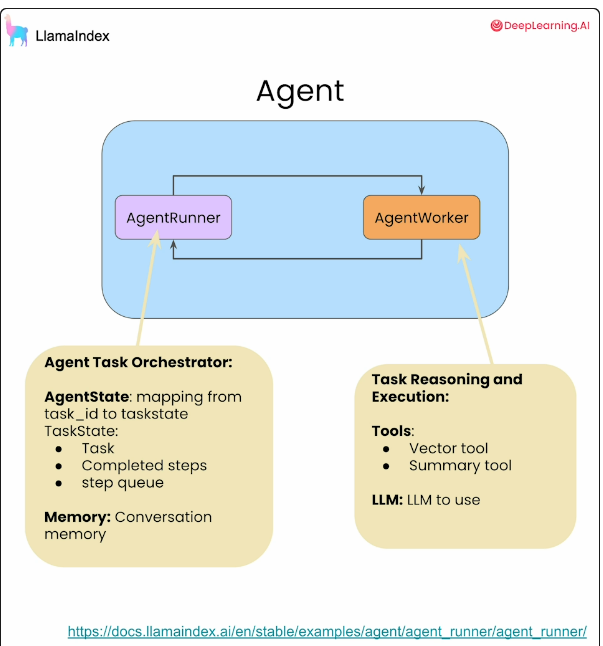

In [57]:
Image(filename="../../Imgs/20240516_201241.png")

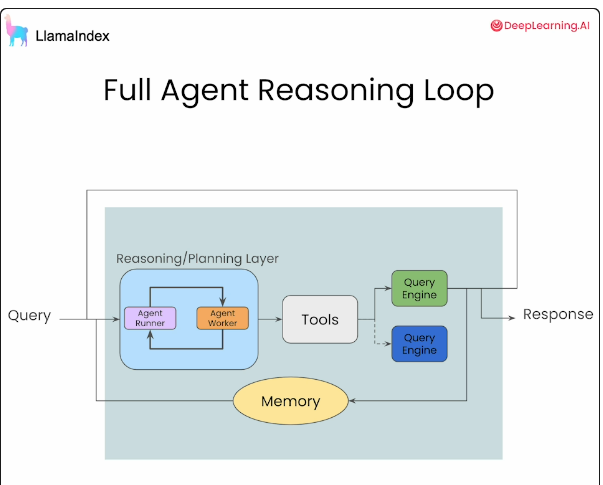

In [58]:
Image(filename="../../Imgs/20240516_201558.png")

In [59]:
## Uncomment if not ran before
## vector_tool, summary_tool as defined before
#import nest_asyncio
#nest_asyncio.apply()

In [60]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    [vector_tool, summary_tool], 
    llm=llm, 
    verbose=True
)
agent = AgentRunner(agent_worker)

#### Let's make a two steps query

In [61]:
response = agent.query(
    "What are the MetaGPT comparisons with ChatDev described on page 8,"
    "and how Agents communicate with other agents?"
)

Added user message to memory: What are the MetaGPT comparisons with ChatDev described on page 8,and how Agents communicate with other agents?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: query_engine_tool with args: {"input": "MetaGPT comparisons with ChatDev described on page 8"}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Function Output ===
MetaGPT demonstrates superior performance compared to ChatDev across various metrics in the SoftwareDev dataset. Specifically, MetaGPT achieves an executability score of 3.75, significantly highe

In [62]:
print(response.source_nodes[0].get_content(metadata_mode="all"))

page_label: 8
file_name: metagpt.pdf
file_path: ../../Data/metagpt.pdf
file_type: application/pdf
file_size: 16911937
creation_date: 2024-11-09
last_modified_date: 2024-11-09

Preprint
Figure 5: Demo softwares developed by MetaGPT.
in these two public benchmarks. Moreover, as shown in Table 1, MetaGPT outperforms ChatDev on
the challenging SoftwareDev dataset in nearly all metrics. For example, considering the executabil-
ity, MetaGPT achieves a score of 3.75, which is very close to 4 (flawless). Besides, it takes less time
(503 seconds), clearly less than ChatDev. Considering the code statistic and the cost of human revi-
sion, it also significantly outperforms ChatDev. Although MetaGPT requires more tokens (24,613
or 31,255 compared to 19,292), it needs only 126.5/124.3 tokens to generate one line of code. In
contrast, ChatDev uses 248.9 tokens. These results highlight the benefits of SOPs in collabora-
tions between multiple agents. Additionally, we demonstrate the autonomous softwa

In [63]:
response = agent.chat(
    "Tell me about the evaluation datasets used."
)

Added user message to memory: Tell me about the evaluation datasets used.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: query_engine_tool with args: {"input": "evaluation datasets used in MetaGPT"}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Function Output ===
MetaGPT utilizes the SoftwareDev dataset, which includes 70 diverse software development tasks. Additionally, it is evaluated using benchmarks such as HumanEval and MBPP, where it demonstrates superior performance compared to previous approaches.
INFO:httpx:HTTP Request: POST htt

In [64]:
response = agent.chat("Tell me the results over one of the above datasets.")

Added user message to memory: Tell me the results over one of the above datasets.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: query_engine_tool with args: {"input": "MetaGPT results on SoftwareDev dataset"}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Function Output ===
MetaGPT demonstrates strong performance on the SoftwareDev dataset, achieving an average executability score of 3.75, which is significantly higher than ChatDev's score of 2.25. In terms of running time, MetaGPT requires 503 seconds, compared to ChatDev's 762 seconds. 

## Lower-Level: Debuggability and Control

In [77]:
agent_worker = FunctionCallingAgentWorker.from_tools(
    [vector_tool, summary_tool], 
    llm=llm, 
    verbose=True
)
agent = AgentRunner(agent_worker)

In [78]:
task = agent.create_task(
    "Tell me about the agent roles in MetaGPT, "
    "and then how they communicate with each other."
)

In [79]:
step_output = agent.run_step(task.task_id)

Added user message to memory: Tell me about the agent roles in MetaGPT, and then how they communicate with each other.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: query_engine_tool with args: {"input": "agent roles in MetaGPT"}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Function Output ===
In MetaGPT, there are five defined roles within the framework of a simulated software company: Product Manager, Architect, Project Manager, Engineer, and QA Engineer. Each role has specific responsibilities and skills tailored to contribute to the 

In [80]:
completed_steps = agent.get_completed_steps(task.task_id)
print(f"Num completed for task {task.task_id}: {len(completed_steps)}")
print(completed_steps[0].output.sources[0].raw_output)

Num completed for task 58127451-7421-4085-947d-0c1c49c32aff: 1
In MetaGPT, there are five defined roles within the framework of a simulated software company: Product Manager, Architect, Project Manager, Engineer, and QA Engineer. Each role has specific responsibilities and skills tailored to contribute to the overall workflow. For instance, the Product Manager focuses on business-oriented analysis, while the Engineer is responsible for programming tasks. The specialization of these roles allows for the breakdown of complex work into smaller, more manageable tasks, facilitating collaboration among agents with diverse expertise.


In [81]:
upcoming_steps = agent.get_upcoming_steps(task.task_id)
print(f"Num upcoming steps for task {task.task_id}: {len(upcoming_steps)}")
upcoming_steps[0]

Num upcoming steps for task 58127451-7421-4085-947d-0c1c49c32aff: 1


TaskStep(task_id='58127451-7421-4085-947d-0c1c49c32aff', step_id='de99c93f-dc04-438e-9627-70d0f597d1bd', input=None, step_state={}, next_steps={}, prev_steps={}, is_ready=True)

### Inserting a new step in the task

In [82]:
step_output = agent.run_step(
    task.task_id, input="What about how agents share information?"
)

Added user message to memory: What about how agents share information?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== LLM Response ===
In MetaGPT, agents share information through a structured communication protocol that enhances efficiency. They utilize a shared message pool to publish and subscribe to structured messages relevant to their roles. This system allows agents to exchange information directly without the need for one-to-one inquiries, thereby reducing communication overhead.

Each agent has a defined profile that includes their specific role, goals, and constraints, which enables them to focus on task-related information. The subscription mechanism allows agents to filter and receive only the information pertinent to their tasks, minimizing distractions from irrelevant details.

Moreover, agents communicate through structured outputs such as docum

In [83]:
print(step_output.is_last)
#step_output = agent.run_step(task.task_id)   ##Error

True


In [84]:
response = agent.finalize_response(task.task_id)

In [85]:
print(str(response))

In MetaGPT, agents share information through a structured communication protocol that enhances efficiency. They utilize a shared message pool to publish and subscribe to structured messages relevant to their roles. This system allows agents to exchange information directly without the need for one-to-one inquiries, thereby reducing communication overhead.

Each agent has a defined profile that includes their specific role, goals, and constraints, which enables them to focus on task-related information. The subscription mechanism allows agents to filter and receive only the information pertinent to their tasks, minimizing distractions from irrelevant details.

Moreover, agents communicate through structured outputs such as documents and diagrams, rather than dialogue. This ensures that all necessary information is conveyed clearly and completely, helping to prevent information distortion and overload. This structured approach promotes effective collaboration among agents by ensuring tha

# 5th. Example - [Building a Multi-Document Agent](https://docs.llamaindex.ai/en/stable/examples/agent/multi_document_agents/)

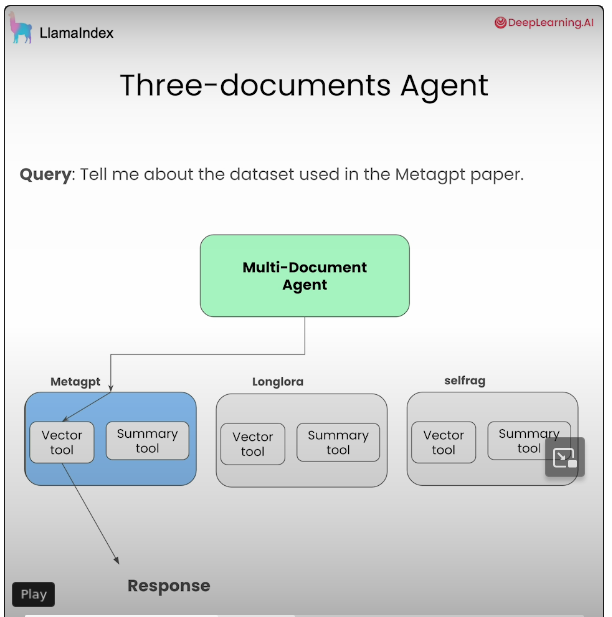

In [87]:
Image(filename="../../Imgs/20240516_230659.png") 

## Setup an Multi-Document Agent over 3 papers

In [88]:
## Uncomment if not ran before
#import nest_asyncio
#nest_asyncio.apply()
#from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, SummaryIndex
#from llama_index.core.node_parser import SentenceSplitter
#from llama_index.core.tools import FunctionTool, QueryEngineTool
#from llama_index.core.vector_stores import MetadataFilters, FilterCondition
from typing import List, Optional
from pathlib import Path

In [89]:
def get_doc_tools(file_path: str, name: str,) -> str:
    """Get vector query and summary query tools from a document."""

    documents = SimpleDirectoryReader(input_files=[file_path]).load_data()
    splitter = SentenceSplitter(chunk_size=1024)
    nodes = splitter.get_nodes_from_documents(documents)
    vector_index = VectorStoreIndex(nodes)
    
    def vector_query(query: str, page_numbers: Optional[List[str]] = None) -> str:
        """Use to answer questions over a given paper.
    
        Useful if you have specific questions over the paper.
        Always leave page_numbers as None UNLESS there is a specific page you want to search for.
    
        Args:
            query (str): the string query to be embedded.
            page_numbers (Optional[List[str]]): Filter by set of pages. Leave as NONE 
                if we want to perform a vector search
                over all pages. Otherwise, filter by the set of specified pages.
        
        """
    
        page_numbers = page_numbers or []
        metadata_dicts = [{"key": "page_label", "value": p} for p in page_numbers]
        query_engine = vector_index.as_query_engine(similarity_top_k=2,
                                                    filters=MetadataFilters.from_dicts(metadata_dicts,
                                                                                       condition=FilterCondition.OR)
                                                   )
        response = query_engine.query(query)
        return response
    
    vector_query_tool = FunctionTool.from_defaults(name=f"vector_tool_{name}", fn=vector_query)
    
    summary_index = SummaryIndex(nodes)
    summary_query_engine = summary_index.as_query_engine(response_mode="tree_summarize",                                                  use_async=True,)
    summary_tool = QueryEngineTool.from_defaults(name=f"summary_tool_{name}",
                                                 query_engine=summary_query_engine,
                                                 description=(f"Useful for summarization questions related to {name}"),)

    return vector_query_tool, summary_tool

In [90]:
docs = os.listdir(DOCS_DIR)
docs = [d for d in docs]
docs.sort()
print(f"Files in {DOCS_DIR}")
for doc in docs:
    print(doc)

Files in ../../Data/
.ipynb_checkpoints
1.pdf
Lightroom.jpeg
Sign.png
Vienna_dataset.json
Vienna_image.png
Vienna_mask.png
WarrenCommissionReport.txt
attention.png
axis_report.pdf
california_housing_train.csv
fossils.jpeg
handwritten.jpg
handwritten2.jpg
handwritten3.jpg
hdfc_report.pdf
hr.sqlite
icici_report.pdf
imageToSave.png
imageToSave2.png
kafka_metamorphosis.txt
keynote_recap.mp3
keynote_recap.mp4
knowledge_card.pdf
loftq.pdf
longlora.pdf
lyft_2021.pdf
metagpt.pdf
metra.pdf
new_rag_dataset.json
nyc_text.txt
paul_graham_essay.txt
rag_dataset.json
selfrag.pdf
sound_english.mp3
sound_german.mp3
sound_portuguese.mp3
speech.mp3
swebench.pdf
triangle.png
uber_2021.pdf
values.pdf
vr_mcl.pdf
zipformer.pdf


In [91]:
papers = [
    "../../Data/metagpt.pdf",
    "../../Data/longlora.pdf",
    "../../Data/selfrag.pdf",
]

In [92]:
paper_to_tools_dict = {}
for paper in papers:
    print(f"Getting tools for paper: {paper}")
    vector_tool, summary_tool = get_doc_tools(paper, Path(paper).stem)
    paper_to_tools_dict[paper] = [vector_tool, summary_tool]

Getting tools for paper: ../../Data/metagpt.pdf
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
Getting tools for paper: ../../Data/longlora.pdf
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
Getting tools for paper: ../../Data/selfrag.pdf
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [93]:
initial_tools = [t for paper in papers for t in paper_to_tools_dict[paper]]
print(len(initial_tools))

6


In [94]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    initial_tools, 
    llm=llm, 
    verbose=True
)
agent = AgentRunner(agent_worker)

In [95]:
response = agent.query(
    "Tell me about the evaluation dataset used in LongLoRA, "
    "and then tell me about the evaluation results"
)

Added user message to memory: Tell me about the evaluation dataset used in LongLoRA, and then tell me about the evaluation results
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: vector_tool_longlora with args: {"query": "evaluation dataset used in LongLoRA"}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Function Output ===
The evaluation dataset used in LongLoRA is the proof-pile test set.
=== Calling Function ===
Calling function: vector_tool_longlora with args: {"query": "evaluation results of LongLoRA"}
INFO:httpx:HTTP Request: POST htt

In [96]:
response = agent.query("Give me a summary of both Self-RAG and LongLoRA")
print(str(response))

Added user message to memory: Give me a summary of both Self-RAG and LongLoRA
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: summary_tool_selfrag with args: {"input": "Self-RAG"}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Function Output ===
Self-RAG, or Self-Reflective Retrieval-Augmented Generation, is a framework designed to enhance the quality and factuality of large language models (LLMs) through on-demand retrieval and self-reflection. It addresses the common issue of factual inaccuracies in LLM outputs by allowing the model to determine when to retrieve relevant information and to critique its own generated responses.

The framework operates by training a single LLM to generate text wh

## Setup an Multi-Document Agent over 10 papers

In [97]:
papers = [
    "../../Data/metagpt.pdf",
    "../../Data/longlora.pdf",
    "../../Data/loftq.pdf",
    "../../Data/swebench.pdf",
    "../../Data/selfrag.pdf",
    "../../Data/zipformer.pdf",
    "../../Data/values.pdf",
    "../../Data/knowledge_card.pdf",
    "../../Data/metra.pdf",
    "../../Data/vr_mcl.pdf"
]

In [98]:
paper_to_tools_dict = {}
for paper in papers:
    print(f"Getting tools for paper: {paper}")
    vector_tool, summary_tool = get_doc_tools(paper, Path(paper).stem)
    paper_to_tools_dict[paper] = [vector_tool, summary_tool]

Getting tools for paper: ../../Data/metagpt.pdf
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
Getting tools for paper: ../../Data/longlora.pdf
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
Getting tools for paper: ../../Data/loftq.pdf
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
Getting tools for paper: ../../Data/swebench.pdf
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
Getting tools for paper: ../../Data/selfrag.pdf
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.c

## Extend the Agent with Tool Retrieval

In [99]:
all_tools = [t for paper in papers for t in paper_to_tools_dict[paper]]

### Define an "object" index and retriever over these tools

In [100]:
#from llama_index.core import VectorStoreIndex
from llama_index.core.objects import ObjectIndex

obj_index = ObjectIndex.from_objects(
    all_tools,
    index_cls=VectorStoreIndex,
)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [101]:
obj_retriever = obj_index.as_retriever(similarity_top_k=3)

### The tools will be chosen by similarity

In [102]:
tools = obj_retriever.retrieve(
    "Tell me about the eval dataset used in MetaGPT and SWE-Bench"
)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [103]:
for t in tools:
    print(t.metadata)

ToolMetadata(description='Useful for summarization questions related to metagpt', name='summary_tool_metagpt', fn_schema=<class 'llama_index.core.tools.types.DefaultToolFnSchema'>, return_direct=False)
ToolMetadata(description='Useful for summarization questions related to metra', name='summary_tool_metra', fn_schema=<class 'llama_index.core.tools.types.DefaultToolFnSchema'>, return_direct=False)
ToolMetadata(description='Useful for summarization questions related to swebench', name='summary_tool_swebench', fn_schema=<class 'llama_index.core.tools.types.DefaultToolFnSchema'>, return_direct=False)


In [104]:
#from llama_index.core.agent import FunctionCallingAgentWorker
#from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    tool_retriever=obj_retriever,
    llm=llm, 
    system_prompt=""" \
You are an agent designed to answer queries over a set of given papers.
Please always use the tools provided to answer a question. Do not rely on prior knowledge.\

""",
    verbose=True
)
agent = AgentRunner(agent_worker)

In [105]:
response = agent.query(
    "Tell me about the evaluation dataset used "
    "in MetaGPT and compare it against SWE-Bench"
)
print(str(response))

Added user message to memory: Tell me about the evaluation dataset used in MetaGPT and compare it against SWE-Bench
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: summary_tool_metagpt with args: {"input": "evaluation dataset"}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Function Output ===
The evaluation datasets used in the experiments include HumanEval, which consists of 164 handwritten programming tasks, and MBPP, which contains 427 Python tasks covering core concepts and standard library features. Additionally, a self-generated datas

In [106]:
response = agent.query(
    "Compare and contrast the LoRA papers (LongLoRA, LoftQ). "
    "Analyze the approach in each paper first. "
)

Added user message to memory: Compare and contrast the LoRA papers (LongLoRA, LoftQ). Analyze the approach in each paper first. 
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: summary_tool_longlora with args: {"input": "Analyze the approach in the LongLoRA paper."}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Function Output ===
The LongLoRA approach introduces an efficient method for fine-tuning large language models (LLMs) to extend their context lengths significantly while minimizing computational costs. It combines two key innovations